# Mask R-CNN - Train on NewShapes Dataset

### Notes from implementation

This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 


In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, random, math, re, gc, time, platform, pickle
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
# import tensorflow as tf
# import keras
import pprint
# import keras.backend as KB
sys.path.append('../..')

# import mrcnn.model     as modellib
import mrcnn.visualize as visualize
# import mrcnn.shapes    as shapes
import mrcnn.newshapes as new_shapes
from mrcnn.config      import Config
from mrcnn.utils        import log
from mrcnn.dataset     import Dataset 

from mrcnn.utils       import stack_tensors, stack_tensors_3d
from mrcnn.datagen     import data_generator, load_image_gt
# # Root directory of the project
# ROOT_DIR = os.getcwd()
# MODEL_PATH = 'E:\Models'
# # Directory to save logs and trained model
# MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# # Path to COCO trained weights
# COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
# RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

# print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4)


# Build configuration object -----------------------------------------------
config = new_shapes.NewShapesConfig()
config.BATCH_SIZE      = 5                  # Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 5                  # Must match BATCH_SIZE
config.STEPS_PER_EPOCH = 2
config.FCN_INPUT_SHAPE = config.IMAGE_SHAPE[0:2]
config.display() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            200
EPOCHS_TO_RUN                  0
FCN_INPUT_SHAPE                [128 128]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 5
IMAGE_BUFFER                   20
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE   

In [8]:
# Build shape dataset        -----------------------------------------------
# Training dataset
# generate 500 shapes 

dataset_train = new_shapes.NewShapesDataset(config)
dataset_train.load_shapes(500,10)
dataset_train.prepare()


Prepares complete


###  Display some random image samples and their masks 

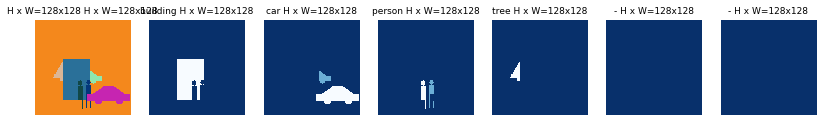

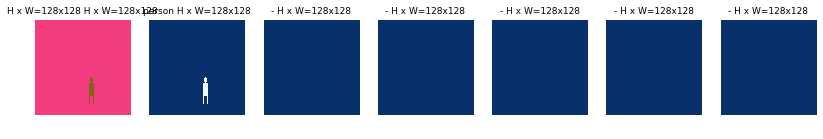

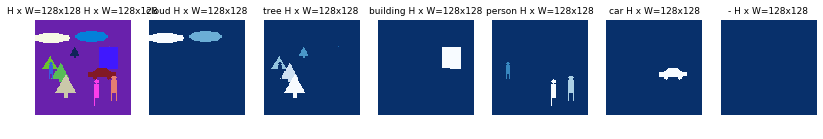

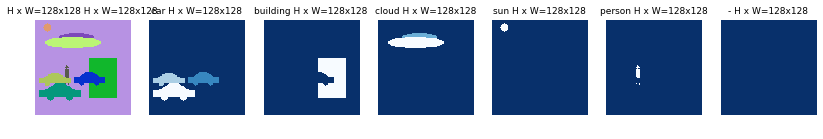

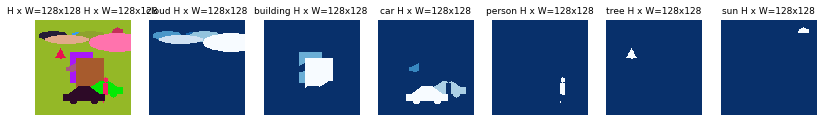

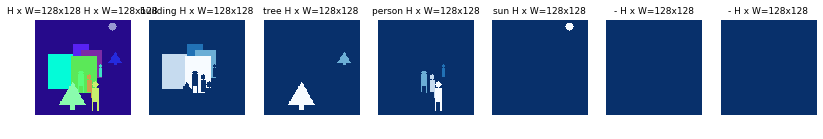

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 6)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=6)

###  Display some random image samples  

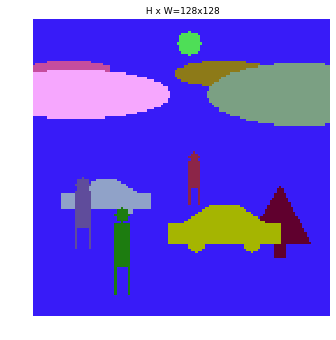

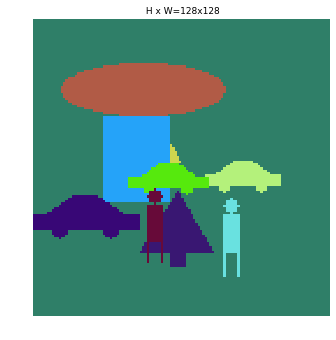

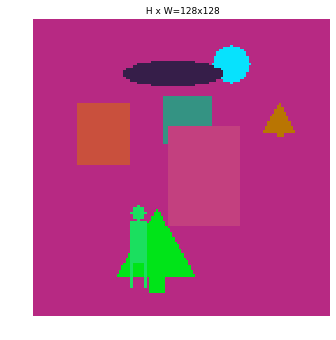

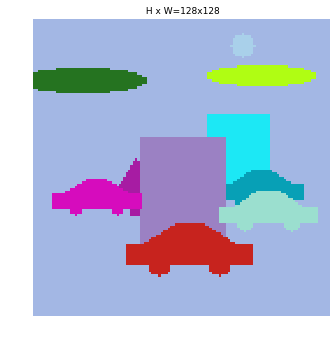

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    visualize.display_images([image], cols = 1, width = 6)         

###  Load and display masks 

(128, 128, 3)


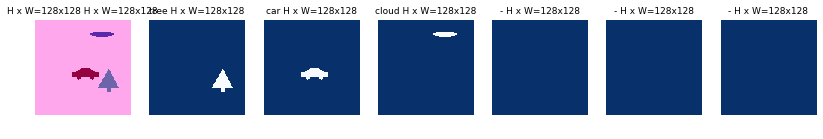

In [11]:
# Load and display random samples
from mrcnn.utils import mask_string
image_id = np.random.choice(dataset_train.image_ids, 1)
image_id = [113]
image = dataset_train.load_image(image_id[0])
mask, class_ids = dataset_train.load_mask(image_id[0])
print(mask.shape)
# for i in range(6):
#     print()
#     print(mask_string(mask[:,:,i]))

visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=6)
# visualize.display_images([image], cols = 1, width = 6)         

###  Define data generators 

In [11]:
train_generator = data_generator(dataset_train, config, shuffle=True, batch_size=100, augment = False)

# val_generator = data_generator(dataset_val, model.config, shuffle=True, batch_size=model.config.BATCH_SIZE,  augment=False)

In [18]:
train_batch_x, train_batch_y = next(train_generator)

In [ ]:

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
image_ids  = [113, 326, 476, 97,174, 381, 488]
image_ids  = [176]
for image_id in image_ids:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
    image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)    
#     print(gt_boxes)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=6)

In [ ]:
np.set_printoptions(linewidth=135,precision=4,threshold=20000)
for img_id in image_ids:
#     print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                    load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=False) 
    print(gt_class_ids.shape, gt_boxes.shape, gt_masks.shape)
#     for i in range(gt_masks.shape[-1]):
#         print('\n',np.array2string(np.where(gt_masks[:,:,i],1,0),max_line_width=134, separator = ''))
    print(gt_boxes)
    print(gt_class_ids)        
    visualize.display_images([image], cols = 1, width = 8)     

####  Image info structure 

In [ ]:
dataset_train.image_info[176]

In [ ]:
img_id = 22

shapes = dataset_train.image_info[img_id]['shapes']
pp.pprint(shapes)
sorted_shapes = []
boxes_ls = []
boxes_xy = []
#--------------------------------------------------
#---- toi sort in an order 
#--------------------------------------------------
# sort_lst = [itm[2][1] for itm in shapes]
# sorted_shape_ind = np.argsort(np.array(sort_lst))[::+1]
# print(sort_lst, '\n',sorted_shape_ind)

# for i in sorted_shape_ind:
#     sorted_shapes.append(shapes[i])
#     x, y, sx, sy = shapes[i][2]
#     boxes_ls.append([y - sy, x - sx, y + sy, x + sx])            
            

for shp in shapes:
    x, y, sx, sy = shp[2]
    boxes_ls.append([y - sy, x - sx, y + sy, x + sx])            
    boxes_xy.append([x - sx, y - sy, x + sx, y + sy])            
    
pp.pprint(boxes_xy)
pp.pprint(sorted_shapes)
boxes = np.array(boxes_ls)
# print(boxes)

In [ ]:
from mrcnn.new_shapes import debug_non_max_suppression
ixs = debug_non_max_suppression(boxes_np, np.arange(boxes_np.shape[0]), 0.29)

In [ ]:
np.set_printoptions(linewidth=100,precision=4, threshold=20000)
image_id = [315]
# from mrcnn.utils import mask_string
# image = dataset_train.load_image(image_id[0])
shapes = dataset_train.image_info[image_id[0]]['shapes']
pp.pprint(shapes)
# mask, class_ids =  dataset_train.load_mask(image_id[0])
hidden =  dataset_train.find_hidden_shapes(shapes,128,128)
# visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=6)
# visualize.display_images([image], cols = 1, width = 6)         

### Display ground truth bboxes from Shapes database (using `load_image_gt` )

Here we are displaying the ground truth bounding boxes as provided by the dataset

In [ ]:

# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 6)
for image_id in image_ids:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
    image, image_meta, gt_class_ids, gt_boxes, gt_masks = \
                load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)    
#     print(gt_boxes)
    visualize.draw_boxes(image, gt_boxes)    

In [ ]:
img = 0
image_id = img_meta[img,0]
print('Image id: ',image_id)
p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
            load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
print(p_gt_bbox[0:3,:])
print(p_gt_class_id)
visualize.draw_boxes(p_original_image, p_gt_bbox[0:3])

# image_id = img_meta[img,0]
# print('Image id: ',image_id)
# p_original_image, p_image_meta, p_gt_class_id, p_gt_bbox, p_gt_mask =  \
#             load_image_gt(dataset_train, config, image_id, augment=False, use_mini_mask=True)
# # print(p_gt_class_id.shape, p_gt_bbox.shape, p_gt_mask.shape)
# print(p_gt_bbox)
# print(p_gt_class_id)
# visualize.draw_boxes(p_original_image, p_gt_bbox)